<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/05_tranfer_learning_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning

In this section, we are going to:
* Introduce **fine-tuning transfer learning** with Tensorflow
* Introduce the **KerasFunctional API** to build models
* Using small dataset to experiment faster(eg. 10% of training data)
* **Data Augumentation**
* Running a series of experiments on our Food Vision data
* Introduce the **Model Checkpoint** callback

In [1]:
# check if we're using gpu
! nvidia-smi

Tue Jan 30 19:06:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating Helper Functions

This script was gotten from the Deep Learning with TensorFlow Course repo at this [link](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py)

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-30 19:06:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-30 19:06:45 (79.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

##  Let's get the data

This time we're going to see how to use the pre-trained models in `tf.keras.applications` and apply them to our problem.

In [4]:
# get 10% of training data from the food_10_classes dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-01-30 19:06:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.4MB/s    in 8.3s    

2024-01-30 19:06:59 (19.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# check out the number of images and sub-directories
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gr

In [6]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train/"
test_dir ="10_food_classes_10_percent/test/"


In [7]:
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# creating the training and testing datasets
train_dataset_10_percent = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_dataset_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
class_names = train_dataset_10_percent.class_names

In [10]:
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# see  a sample batch of data
for images, labels in train_dataset_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[139.3015    150.11623   141.93097  ]
   [144.89972   153.7881    143.6765   ]
   [158.34232   162.63695   148.85794  ]
   ...
   [112.61128   124.6639    122.81124  ]
   [112.087364  125.37279   125.37279  ]
   [113.03427   127.03427   127.03427  ]]

  [[128.2862    139.91566   129.75685  ]
   [135.46143   144.34981   132.38106  ]
   [144.17761   148.47226   134.55644  ]
   ...
   [105.25951   115.53918   114.54668  ]
   [ 98.64285   110.64285   110.64285  ]
   [ 98.64285   110.64285   110.64285  ]]

  [[118.810745  128.09103   118.37133  ]
   [130.85715   137.74554   126.189735 ]
   [132.18048   136.3278    121.54878  ]
   ...
   [ 94.487915  105.00146   100.99239  ]
   [ 97.579544  107.36526   105.93669  ]
   [ 97.95758   106.5794    105.32542  ]]

  ...

  [[115.029     110.029      81.029    ]
   [114.33335   109.09518    80.214264 ]
   [113.70067   108.27214    79.486404 ]
   ...
   [ 62.255985   65.47699    56.403324 ]
   [ 51.650967   58.253857   48.190357 ]
   [ 

## The TensorFlow Functional API
Building a transfer learning model using the Functional API

In [12]:
from posixpath import dirname
# 1. Create a model
base_model = keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so underlying pre-trained layers aren't updated)
base_model.trainable=False

# 3. Create input layer
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name='input_layer')

#4. Rescaling the input
# x = tf.keras.layers.Rescaling(1./255)(inputs)

# EfficientNetB0 doesn't require rescaling
# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pools the outputs of the base model(aggregates all the most important information, reduces computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"Shape after passing inputs GlobalAveragePooling2D layer: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# fit the model
hist_0 = model_0.fit(
    train_dataset_10_percent,
    epochs=5,
    steps_per_epoch=len(train_dataset_10_percent),
    validation_data=test_dataset,
    validation_steps=int(0.25 * len(test_dataset)),
    callbacks=[create_tensorboard_callback(
        dir_name='transfer_learning',
        experiment_name='10_percent_feature_extraction'
    )]
)

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after passing inputs GlobalAveragePooling2D layer: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240130-190711
Epoch 1/5
24/24 [==============================] - 28s 354ms/step - loss: 1.8824 - accuracy: 0.4093 - val_loss: 1.2966 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 4s 137ms/step - loss: 1.0862 - accuracy: 0.7733 - val_loss: 0.8697 - val_accuracy: 0.8191
Epoch 3/5
24/24 [==============================] - 4s 131ms/step - loss: 0.7800 - accuracy: 0.8360 - val_loss: 0.7076 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 5s 193ms/step - loss: 0.6355 - accuracy: 0.8653 - val_loss: 0.6271 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 5s 175ms/step - loss: 0.5430 - accuracy: 0.8760 - val_loss: 0.5737 - val_accuracy: 0.8

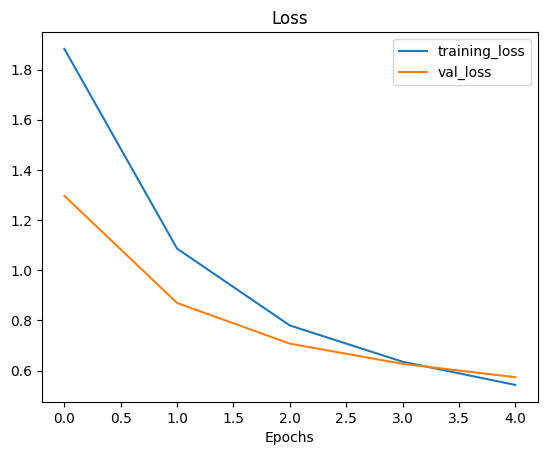

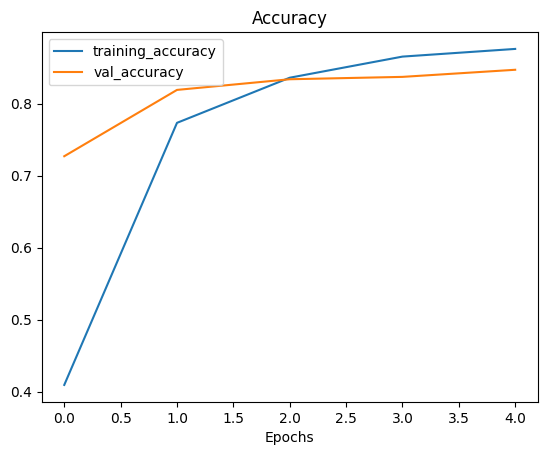

In [13]:
plot_loss_curves(hist_0)

In [14]:
# Evaluate on full test dataset
model_0.evaluate(test_dataset)

79/79 [==============================] - 7s 87ms/step - loss: 0.5602 - accuracy: 0.8504


[0.5602474212646484, 0.8503999710083008]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [16]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


## Getting a feature vector from a trained model
Let's demonstrate the GlobalAveragePoling2D layer

We have a tensor of shape (None, 7, 7, 1280) after our model goes through `base_model`.

But when it passes thtough the GlobalAveragePooling2D layers, it turns into (None, 1280)

Let's use a similar shape tensor of shape (1, 4, 4, 3) and pass it to the GlobalAveragePooling2D.

In [18]:
# Define the input_shape
input_shape = (1, 4, 4, 3)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(shape=input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338894,  0.97772694],
         [ 0.24694404,  0.20573746, -0.52562326],
         [ 0.32410017,  0.02545409, -0.10638496],
         [-0.63694745,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815628,  0.23479679, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [19]:
# Pass the tensor into a GlobalAveragePooling2D layer
global_average_pool_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
global_average_pool_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
global_average_pool_tensor.shape

TensorShape([1, 3])

In [21]:
reduced_mean = tf.reduce_mean(input_tensor, axis=[1,2])
global_average_pool_tensor == reduced_mean

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

In [22]:
# Trying the same procedure as above but with GlobalMaxPool2D
global_max_pool_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pool_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [23]:
reduced_max = tf.reduce_max(input_tensor, axis=[1,2])
global_max_pool_tensor == reduced_max

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

🖊 A feature vector is a compressed version of the input data based on how the model sees it

## Running series of transfer learning experiments

1. `model_1` - use feature extraction and data augumentation transfer learning with 1% of training data.

2. `model_2` - use feature extraction and data augumentation transfer learning with 10% of training data.

3. `model_3` - use fine-tuning transfer learning on 10% training data with data augumentation

4. `model_4` - use fine-tuning transfer learning on 100% training data with data augumentation

🖊: All experiments will be using the same dataset to ensure consistency.

In [24]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-01-30 19:08:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  25.2MB/s    in 6.2s    

2024-01-30 19:08:16 (20.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [25]:
# Create training and test directories
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir_1_percent = '10_food_classes_1_percent/test/'

In [26]:
# walk through directory
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [27]:
# setup dataset
train_dataset_1_percent = image_dataset_from_directory(
    directory=train_dir_1_percent,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_dataset_1_percent = image_dataset_from_directory(
    directory=test_dir_1_percent,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augumentation right in the model

In [28]:
import tensorflow as tf
import keras
from keras import layers

# create data augumentation stage with horizontal flipping, rotations, zooms, etc
data_augumentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # No need to rescale since efficientnet b0 has a rescaling layer
])

## Testing the augumentton layer and visualizing

Text(0.5, 1.0, 'Augumented image')

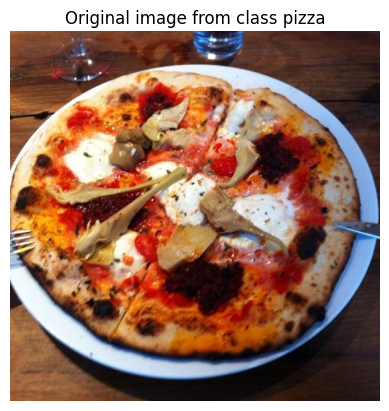

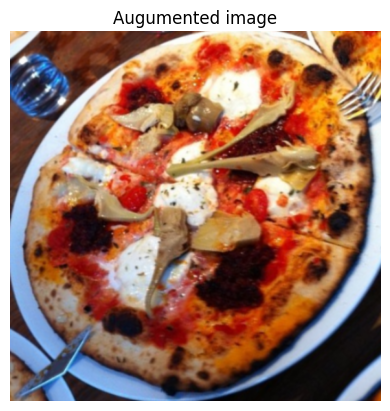

In [29]:
# view a random image and compare to its augumented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_dataset_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
image_path = target_dir + '/' + random_image
# image_path
# load the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original image from class {target_class}')

# augument the image
augumented_image = data_augumentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augumented_image)/255)
plt.axis('off')
plt.title("Augumented image")

## Model 1 : Feature extraction and data augumentation transfer learning with 1% of training data.


In [30]:
# setup input shape and base model, freeze base_model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the input layer
inputs = layers.Input(shape=input_shape, name='input_layer')
# add data augumentation layer
x = data_augumentation(inputs)
# give base model inputs after augumentation and don't train
x = base_model(x, training=False)
# pool output feature of base_model
x = layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)  # inputs are passed to layers outside their parenthesis, while for whole models inputs are passed inside
# put a dense layer as the output
outputs = layers.Dense(10, activation='softmax')(x)

# make a model
model_1 = keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

# fit
hist_1_percent = model_1.fit(train_dataset_1_percent,
                             steps_per_epoch=len(train_dataset_1_percent),
                             epochs=5,
                             validation_data=test_dataset_1_percent,
                             validation_steps=(.25 * len(test_dataset_1_percent)),
                             callbacks=[create_tensorboard_callback(
                                 dir_name="transfer_learning",
                                 experiment_name='1_percent_feature_extraction_data_aug'
                             )])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction_data_aug/20240130-190823
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.2956 - accuracy: 0.1571 - val_loss: 2.1821 - val_accuracy: 0.2031
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 1.9981 - accuracy: 0.3143 - val_loss: 2.0771 - val_accuracy: 0.2703
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8276 - accuracy: 0.5571 - val_loss: 1.9629 - val_accuracy: 0.3656
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.6672 - accuracy: 0.6286 - val_loss: 1.8748 - val_accuracy: 0.4281
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.5248 - accuracy: 0.7571 - val_loss: 1.7913 - val_accuracy: 0.4859


In [31]:
model_1.evaluate(test_dataset_1_percent)

79/79 [==============================] - 6s 74ms/step - loss: 1.7882 - accuracy: 0.4828


[1.788221836090088, 0.4828000068664551]

In [32]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling_layer (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (5

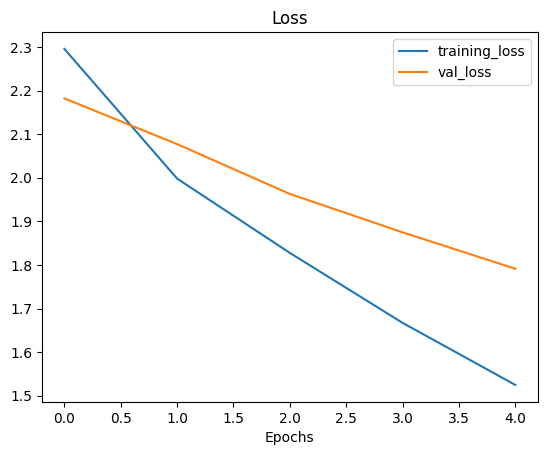

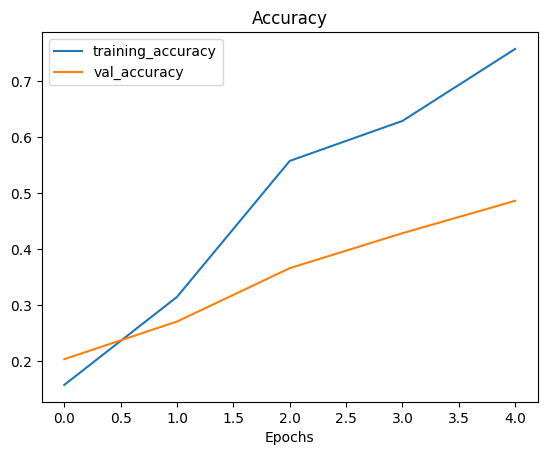

In [33]:
plot_loss_curves(hist_1_percent)

## Model_2 : Feature extraction and data augumentation transfer learning with 10% of training data.

In [34]:
# get 10 percent data, already in a previous cell
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir_10_percent = '10_food_classes_10_percent/test'

In [35]:
# set data inputs

train_dataset_10_percent
test_dataset_10_percent = test_dataset

In [36]:
# create model_2 with data augumentation in-built
from keras.models import Sequential

data_augumentation = Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name='data_augumentation')

In [37]:
# set up base model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# create inputs and outputs
inputs = layers.Input(input_shape, name='inpout_layer')
x = data_augumentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)
outputs = layers.Dense(10, activation='softmax')(x)

# create modeel_2
model_2 = keras.Model(inputs, outputs)

# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


In [38]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inpout_layer (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequen  (None, None, None, 3)     0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                           

### Creating a Model Checkpoint callback

In [39]:
# set checkpoint path
checkpoint_path = '10_percent_model_checkpoints_weights/checkont.ckpt'

# create a ModelCheckpoint callback that saves a modeel's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights=True,
                                                      save_best_only=False,
                                                      save_freq='epoch',
                                                      verbose=1)

In [40]:
# fit the model
initial_epochs = 5
hist_2_10_percent = model_2.fit(train_dataset_10_percent,
                                epochs=initial_epochs,
                                steps_per_epoch=len(train_dataset_10_percent),
                                validation_data=test_dataset_10_percent,
                                validation_steps=int(0.25 * len(test_dataset_10_percent)),
                                callbacks=[create_tensorboard_callback(
                                    dir_name='transfer_learning',
                                    experiment_name='10_percent_feature_extraction_data_aug'
                                ), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction_data_aug/20240130-190924
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9797 - accuracy: 0.3680
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkont.ckpt
24/24 [==============================] - 66s 3s/step - loss: 1.9797 - accuracy: 0.3680 - val_loss: 1.4562 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3606 - accuracy: 0.6507
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkont.ckpt
24/24 [==============================] - 47s 2s/step - loss: 1.3606 - accuracy: 0.6507 - val_loss: 1.0353 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.7467
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkont.ckpt
24/24 [==============================] - 46s 2s/step - loss: 1.0388 - accuracy: 0.7467 - val_loss: 0.8365 - val_accuracy: 0.8141


In [41]:
model_0.evaluate(test_dataset)

79/79 [==============================] - 7s 76ms/step - loss: 0.5602 - accuracy: 0.8504


[0.5602473020553589, 0.8503999710083008]

In [42]:
results_model_2 = model_2.evaluate(test_dataset)
results_model_2

79/79 [==============================] - 6s 72ms/step - loss: 0.6549 - accuracy: 0.8388


[0.6549002528190613, 0.8388000130653381]

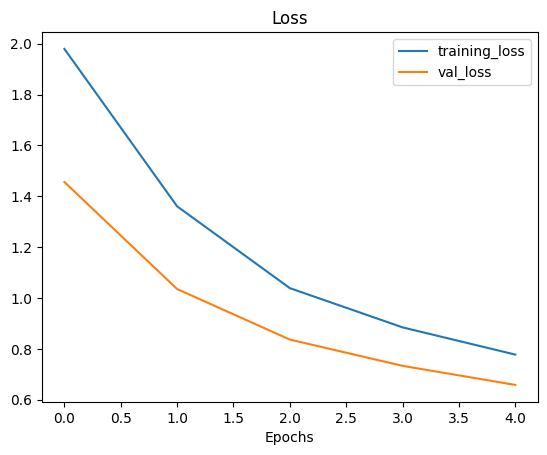

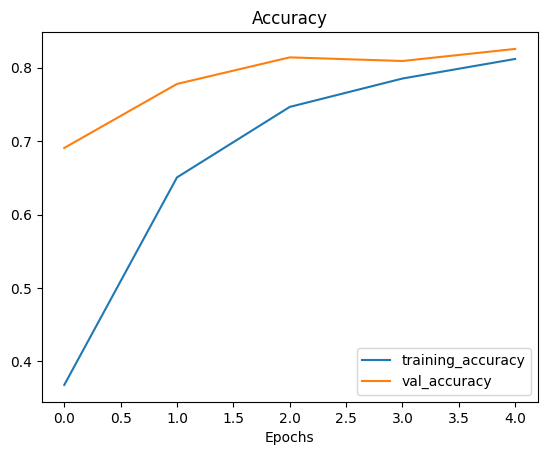

In [43]:
# plot loss curves
plot_loss_curves(hist_2_10_percent)

### Loading in Checkpointed weights
Returns a model to a specific checkpoint by loading the weights at that checkpoint

In [44]:
# Load in saved model weights and evaluate
model_2.load_weights(checkpoint_path)   #overrides model's weights with the stored weights

In [45]:
# Evaluate model_2 wihth loaded weights
loaded_weights_model2_results = model_2.evaluate(test_dataset)

79/79 [==============================] - 6s 65ms/step - loss: 0.6549 - accuracy: 0.8388


In [46]:
# check if results are the same
results_model_2 == loaded_weights_model2_results

False

In [47]:
# check to see of loaded model results are close to the original results
import numpy as np
np.isclose(np.array(results_model_2), np.array(loaded_weights_model2_results))

array([ True,  True])

## Model 3: Fine tuning an existing model on 10% of the data
Fine-tuning usually works best after training a model with large data

In [48]:
# layers in loaded model
model_2.layers

In [49]:
# check what layers are trainable
for layer in model_2 .layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fe2e29f3730> True
<keras.src.engine.sequential.Sequential object at 0x7fe2e2014a00> True
<keras.src.engine.functional.Functional object at 0x7fe2e0b45300> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe2e29f3070> True
<keras.src.layers.core.dense.Dense object at 0x7fe2e0b09570> True


In [50]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model to True
base_model.trainable = True
# freeze all layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model(done every time a change is made)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                # when fine-tuning, you typically want to reduce learning rate by 10x
                metrics=['accuracy'])

# check which layer is tune-able
for layer_num, layer in enumerate(model_2.layers):
    print(f"{layer_num}) {layer.name}: {layer.trainable}")


0) inpout_layer: True
1) data_augumentation: True
2) efficientnetb0: True
3) global_avg_pooling: True
4) dense_1: True


In [51]:
len(model_2.trainable_variables)

12

In [52]:
# fine-tune for another 5  epochs
fine_tune_epochs = initial_epochs + 5

# refit the model

hist_finetune_10_percent = model_2.fit(train_dataset_10_percent,
                                epochs=fine_tune_epochs,
                                steps_per_epoch=len(train_dataset_10_percent),
                                validation_data=test_dataset,
                                validation_steps=int(0.25 * len(test_dataset)),
                                initial_epoch=hist_2_10_percent.epoch[-1], # start training from previous last epoch
                                callbacks=[create_tensorboard_callback(
                                    dir_name='transfer_learning',
                                    experiment_name='10_percent_finetune_last_10'
                                )])

Saving TensorBoard log files to: transfer_learning/10_percent_finetune_last_10/20240130-191508
Epoch 5/10
24/24 [==============================] - 30s 783ms/step - loss: 0.6750 - accuracy: 0.7893 - val_loss: 0.5157 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 14s 556ms/step - loss: 0.5426 - accuracy: 0.8373 - val_loss: 0.4645 - val_accuracy: 0.8569
Epoch 7/10
24/24 [==============================] - 15s 604ms/step - loss: 0.4926 - accuracy: 0.8533 - val_loss: 0.4712 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 14s 596ms/step - loss: 0.4291 - accuracy: 0.8653 - val_loss: 0.4775 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 15s 625ms/step - loss: 0.3978 - accuracy: 0.8827 - val_loss: 0.4477 - val_accuracy: 0.8487
Epoch 10/10
24/24 [==============================] - 14s 551ms/step - loss: 0.3488 - accuracy: 0.8920 - val_loss: 0.4489 - val_accuracy: 0.8503


In [53]:
results_finetune_10_percent = model_2.evaluate(test_dataset)
results_finetune_10_percent

79/79 [==============================] - 5s 65ms/step - loss: 0.4416 - accuracy: 0.8536


[0.44159549474716187, 0.853600025177002]

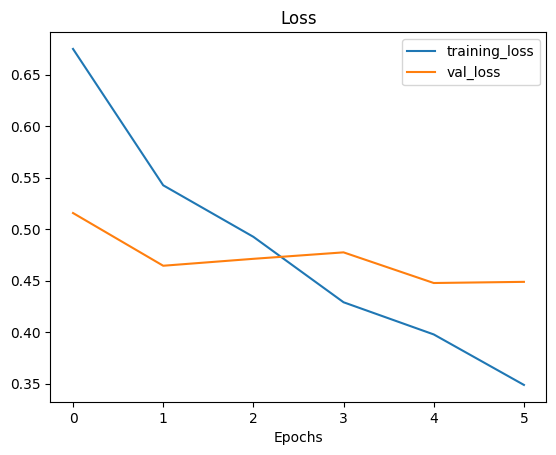

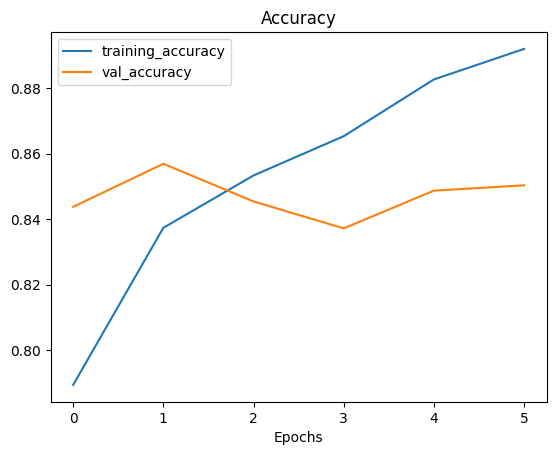

In [54]:
plot_loss_curves(hist_finetune_10_percent)

In [59]:
# Let's create a functon to compare training histories

def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two Tensorflow model history objects
    """
    # Get original history metrics
    org_acc = original_history.history['accuracy']
    org_loss = original_history.history['loss']
    org_val_acc = original_history.history['val_accuracy']
    org_val_loss = original_history.history['val_loss']

    # Combine original history with new history
    total_acc = org_acc + new_history.history['accuracy']
    total_loss = org_loss + new_history.history['loss']

    total_val_acc = org_val_acc + new_history.history['val_accuracy']
    total_val_loss = org_val_loss + new_history.history['val_loss']

    # make plots
    # Accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label="Validation Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
    plt.legend(loc='lower right')
    plt.title("Training and Validation Accuracy")

    # Loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label="Training Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
    plt.legend(loc='upper right')
    plt.title("Training and Validation Loss")

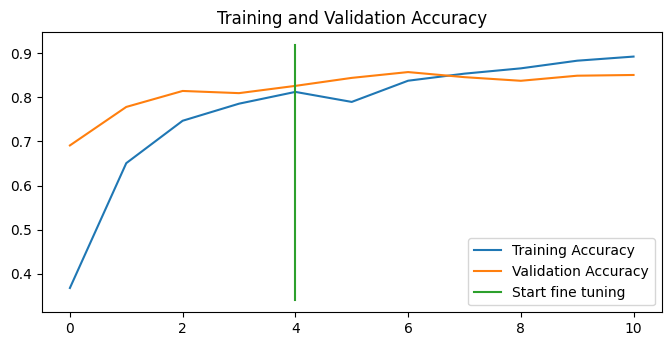

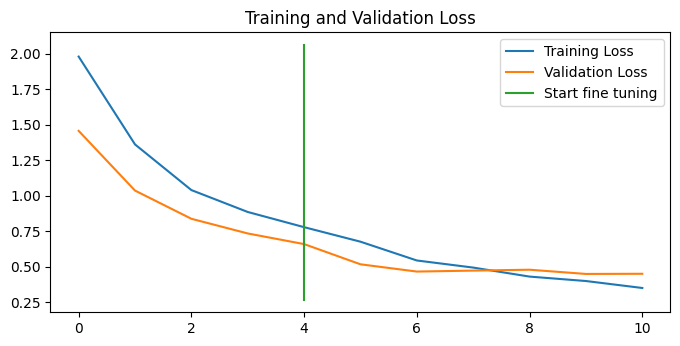

In [60]:
compare_histories(original_history=hist_2_10_percent,
                  new_history=hist_finetune_10_percent,
                  initial_epochs=5)